Dnes si vyzkoušíme deep reinforcement learning a budeme řešit CartPole pomocí (deep) Q-learning agenta. Poté to rozšíříme na actor-critic agenta.

# Deep Q-learning

Nadefinujeme si síť, která predikuje hodnoty Q funkce. Trénujeme ji na datech z tzv. "replay bufferu" - historický seznam stavů, akcí a rewardů.
Loss pak bude MSE mezi predikovanou hodnotou ($Q(s, a)$, kde $s$ je předchozí stav a $a$ zvolená akce) a odhadem Q funkce dle Bellmanovy rovnice ($R + \gamma \cdot \max Q(s', a') $, kde stav $s'$ jsme dosáhli z $s$ po provedení akce $a$ a získali jsme reward $R$)

In [ ]:
# loosely based on https://keon.io/deep-q-learning/

import random

import tensorflow as tf
import numpy as np
import gymnasium as gym

class DQNAgent:
    
    def __init__(self, num_inputs, num_outputs, batch_size = 32, num_batches = 16):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.batch_size = batch_size
        self.num_batches = num_batches
        self.eps = 1.0
        self.eps_decay = 0.995
        self.gamma = 0.95
        self.exp_buffer = []
        self.build_model()
    
    # vytvari model Q-site
    def build_model(self):
        self.model = tf.keras.models.Sequential([tf.keras.layers.Dense(24, input_dim=self.num_inputs),
                                                 tf.keras.layers.ReLU(),
                                                 tf.keras.layers.Dense(24, activation=tf.nn.relu),
                                                 tf.keras.layers.Dense(self.num_outputs, activation='linear')])
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.model.compile(optimizer=opt, loss='mse', run_eagerly=True)
        
    # returns agent's action - epsilon greedy when training and the best one otherwise
    def action(self, state, train=False):
        if train and np.random.uniform() < self.eps:
            return np.random.randint(self.num_outputs)
        else: 
            return np.argmax(self.model.predict(state, verbose=False)[0])
        
    # save experience to buffer
    def record_experience(self, exp):
        self.exp_buffer.append(exp)
        if len(self.exp_buffer) > 2000:
            self.exp_buffer = self.exp_buffer[-2000:]
    
    # If you want to use the target network, the following method copies weights from
    # a given Network to the current one.
    def copy_weights_from(self, other):
        for var, other_var in zip(self.model.variables, other.model.variables):
            var.assign(other_var)
        self.eps = other.eps

    # train based on buffer
    def train(self):
        import pprint
        if (len(self.exp_buffer) <= self.batch_size):
            return
        
        for _ in range(self.num_batches):
            batch = random.sample(self.exp_buffer, self.batch_size)
            #pprint.pprint(batch)
            states = np.array([s for (s, _, _, _, _) in batch])
            next_states = np.array([ns for (_, _, _, ns, _) in batch])
            states = states.reshape((-1, self.num_inputs))
            next_states = next_states.reshape((-1, self.num_inputs))
            pred = self.model.predict(states, verbose=False)
            next_pred = self.model.predict(next_states, verbose=False)
            # compute the target values
            for i, (s, a, r, ns, d) in enumerate(batch):
                pred[i][a] = r
                if not d:
                    pred[i][a] = r + self.gamma * np.amax(next_pred[i])

            self.model.fit(states, pred, epochs=1, verbose=False)
        # decrease epsilon for the epsilon-greedy strategy
        if self.eps > 0.01:
            self.eps = self.eps*self.eps_decay


seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# create agent (4 inputs, 2 actions)
agent = DQNAgent(4, 2)

env = gym.make("CartPole-v1")
print(env.action_space)

# train the network on 1000 runs of the environment
rewards = []
for i in range(1000):
    obs, _ = env.reset()
    obs = np.reshape(obs, newshape=(1, -1))
    done = False
    terminated = False
    R = 0
    t = 0
    while not (done or terminated):
        old_state = obs
        action = agent.action(obs, train=True)
        obs, r, done, terminated, _ = env.step(action)
        
        R += r
        t += 1
        r = r if not (done or terminated) else 10
        obs = np.reshape(obs, newshape=(1, -1))

        agent.record_experience((old_state, action, r, obs, done or terminated))
    agent.train()
    
    rewards.append(R)
    print(i, R)

Let us test, how well the agent solves the problem.

In [5]:
env = gym.make("CartPole-v1")
print(env.action_space)

obs, _ = env.reset()
obs = np.reshape(obs, newshape=(1, -1))
done = False
R = 0
t = 0
while not (done or terminated):
    old_state = obs
    action = agent.action(obs, train=False)
    obs, r, done, terminated, _ = env.step(action)
    obs = np.reshape(obs, newshape=(1, -1))
    R += r
    t += 1
        
print(R)

Discrete(2)
11.0


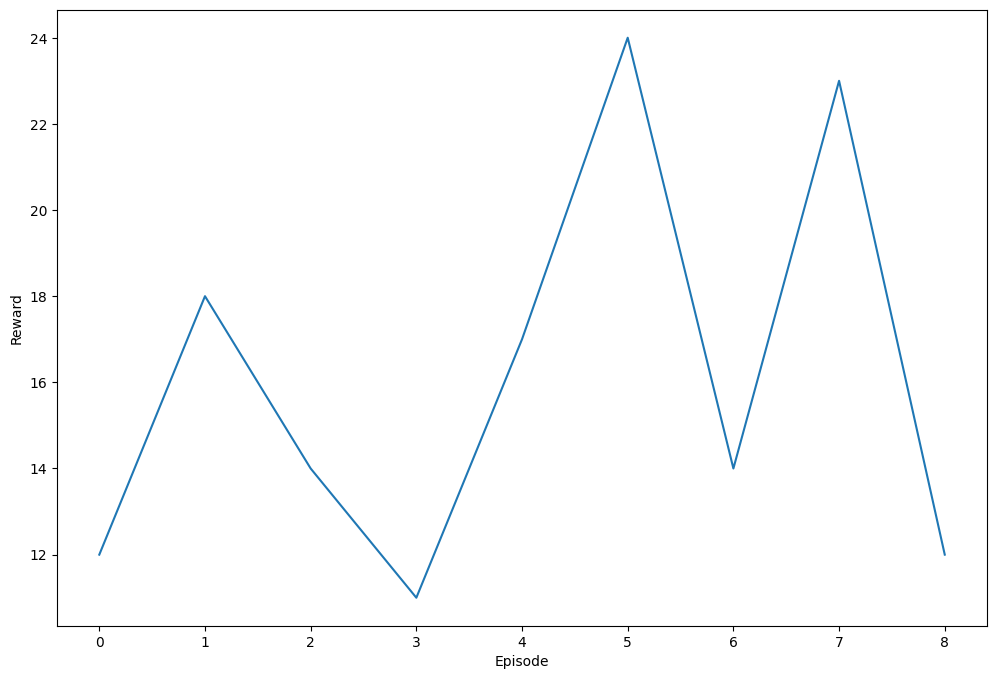

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

# Úkol na cviko

Zkuste vyřešit CartPole (nebo jiné prostředí) pomocí actor-critic.